In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json

# 헬퍼(helper) 라이브러리를 임포트합니다
import os
import pathlib
import datetime
import time

import FinanceDataReader as fdr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

import requests as req
import json

import pandas as pd
import numpy as np

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("GPU ", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

버전:  2.1.0
즉시 실행 모드:  True
GPU  사용 가능


넵튠사용

In [3]:
import neptune

In [4]:
#넵튠콜백
from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)

In [5]:
#기본설정
def data_get(startdate ,symbol):
    raw_data=pd.DataFrame()
    a = fdr.DataReader(symbol ,startdate )['Close']
    raw_data['price']=a
    return raw_data

def data_scaler(df,window_length,):
    scaler = MinMaxScaler()
    dataset_scaled = np.array([scaler.fit_transform(df['price'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['price'])))])
    return dataset_scaled

def data_split(dataset_scaled , train_val_ratio , val_test_ratio):
    x_train, x_valid = train_test_split(dataset_scaled, test_size=train_val_ratio)
    x_valid, x_test = train_test_split(x_valid, test_size=val_test_ratio)

    x_train = x_train.astype('float32')
    x_valid = x_valid.astype('float32')
    x_test = x_test.astype('float32')
    return  x_train,x_valid,x_test

def data_input_train(x,y,batchsize):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.cache().batch(batchsize).repeat()
    return dataset

def data_input_valid(x,y,batchsize):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.batch(batchsize).repeat()
    return dataset


In [6]:

def encoder (input_dataset) :
    input_window = Input(shape=input_dataset.shape[-2:])
    x = Conv1D( 16, 3, activation="relu", padding="same")(input_window) # 128 dims
    #x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding="same")(x) # 64
    x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
    #x = BatchNormalization()(x)
    encoded = MaxPooling1D(2, padding="same")(x) # 3 dims
    encoder = Model(input_window, encoded)
    
    return encoder

def autoencoder(input_dataset):
    """
    Train tensorflow 2.0 keras models
      :param args:
      :param ex:
      :return:
    """
    # This has been tested on TF 2.10
    print(tf.__version__)
    
    input_window = Input(shape=input_dataset.shape[-2:])
    x = Conv1D( 16, 3, activation="relu", padding="same")(input_window) # 128 dims
    #x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding="same")(x) # 64
    x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
    #x = BatchNormalization()(x)
    encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

    x = Conv1D(1, 3, activation="relu", padding="same")(encoded)
    #x = BatchNormalization()(x)
    x = UpSampling1D(2)(x) # 6 dims
    x = Conv1D(16, 2, activation='relu',padding="same")(x) 
    #x = BatchNormalization()(x)
    x = UpSampling1D(2)(x) # 10 dims
    decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) 
    
    autoencoder = Model(input_window, decoded,name='autoencoder_model')
    return autoencoder

In [7]:
START_DATE = '2000-01-04'
SYMBOL = '207940'  
raw_data= data_get(START_DATE, SYMBOL)

In [8]:
WINDOW_LENGTH=128
dataset_scaled = data_scaler(raw_data,WINDOW_LENGTH)

100%|██████████| 740/740 [00:00<00:00, 6533.27it/s]


In [9]:
x_train,x_valid,x_test = data_split(dataset_scaled,
                                    train_val_ratio =0.2,
                                    val_test_ratio =0.3)

In [10]:
BATCH_SIZE = 1024
train_dataset= data_input_train( x_train , x_train , BATCH_SIZE )
valid_dataset= data_input_valid( x_valid , x_valid , BATCH_SIZE )

In [11]:
OPTIMIZER = 'adam'
EPOCH_NR = 20
EVALUATION_INTERVAL = 50

In [12]:
#모델이름
MODEL_NAME = 'test1'
#토큰
TOKEN      = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMzEyODExZTItMTJkOC00Mjk5LTgxNzItMjQwMGNjZGYwMGZmIn0='
#저장할파라미터

PARAMS ={
        'Start_date' : START_DATE,
        'Symbol' : SYMBOL,
        'Window_length' : WINDOW_LENGTH,
        'Batch_size': BATCH_SIZE,
        'Optimizer' : OPTIMIZER,
        'Epoch_nr' :  EPOCH_NR
        }

neptune.init('sgeconomics/sandbox' ,
             api_token = TOKEN)

neptune.create_experiment(name=MODEL_NAME,
                          params =PARAMS , 
                          tags=['adv'])

https://ui.neptune.ai/sgeconomics/sandbox/e/SAN-16


Experiment(SAN-16)

In [13]:
# autoencoder= autoencoder(x_train) #x_train의 shape를 갖는 오토인코더를 만들어라


In [14]:
# autoencoder.compile(optimizer=OPTIMIZER, loss='mse') #컴파일하기

In [15]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    autoencoder= autoencoder(x_train) #x_train의 shape를 갖는 오토인코더를 만들어라
    autoencoder.compile(optimizer=OPTIMIZER, loss='mse') #컴파일하기

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
2.1.0


In [17]:
autoencoder.fit(
                    train_dataset,
                    epochs=EPOCH_NR,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=valid_dataset,
                    validation_steps=30,
                    callbacks=[NeptuneLogger()]
                    )

Train for 50 steps, validate for 30 steps
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
49/50 [============================>.] - ETA: 0s - loss: 0.0049INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
50/50 [==============================] - 2s 39ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 2/20
50/50 [==============================] - 1s 14ms/step - loss: 0.0047 - va

In [18]:
#오토인코더를 이용해서 예측하기
decoded_stocks = autoencoder.predict(x_test)

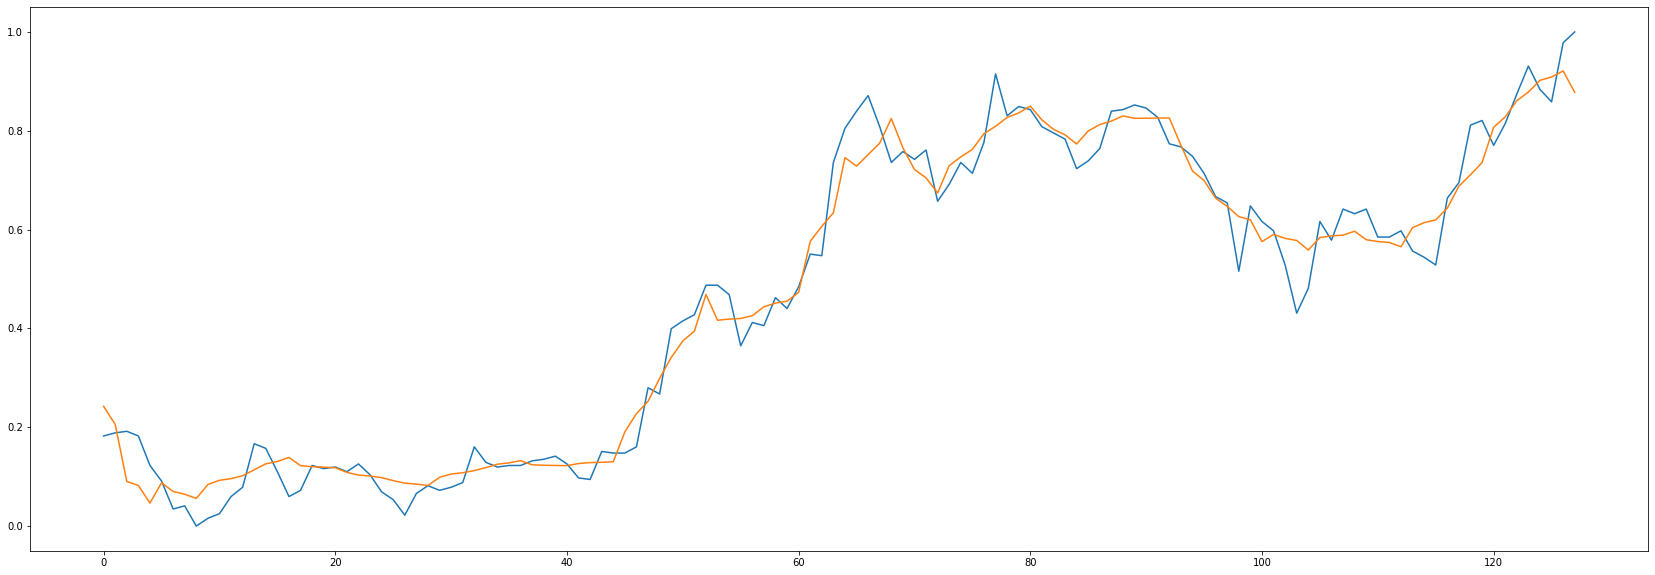

In [19]:
f,ax =plt.subplots(figsize=(29,10))
plt.plot(x_test[3])
plt.plot(decoded_stocks[3])

In [20]:
neptune.log_image('sample', f) 

In [22]:
neptune.stop()

KeyboardInterrupt: 